In [40]:
import cv2
from textwrap import wrap
import shutil
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import os, warnings
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
DATA_PATH = 'C:\\Users\\matus\\PycharmProjects\\VisionTransformer\\data\\data.xlsx'
IMG_DIR = 'C:\\Users\\matus\\PycharmProjects\\VisionTransformer\data\\Training Images'
file_names = sorted(os.listdir(IMG_DIR))

In [10]:
main_df = pd.read_excel(DATA_PATH)
print(main_df.shape)
main_df.head()

(3500, 15)


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [11]:
findings = main_df.iloc[:, -8:]
totals = findings.sum()
totals

N    1140
D    1128
G     215
C     212
A     164
H     103
M     174
O     979
dtype: int64

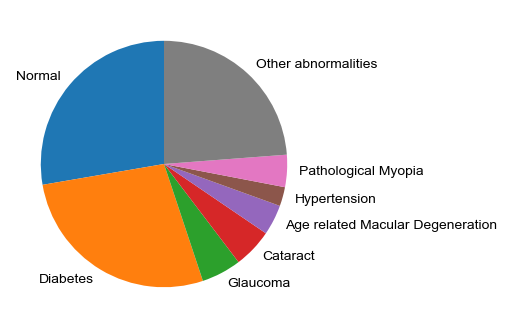

In [12]:
extended_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'Age related Macular Degeneration', 'Hypertension', 'Pathological Myopia', 'Other abnormalities']
plt.pie(totals, labels=extended_labels, startangle=90)
plt.show()

(2000, 2584, 3)


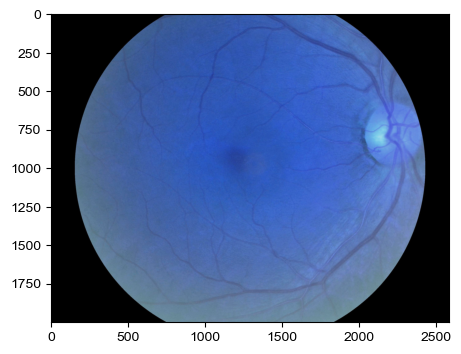

In [13]:
img = '10_right.jpg'
image = cv2.imread(os.path.join(IMG_DIR, img))
plt.imshow(image)
print(image.shape)

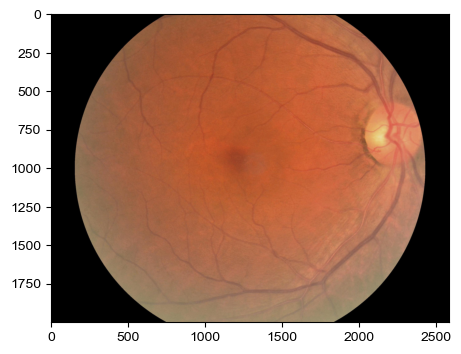

In [14]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image_rgb) 

In [15]:
# Helper functions
def filter_df(df, letter):
    filtered = df.loc[(df[letter] == 1)]
    return filtered

def get_ages_genders(df):
    ages = df['Patient Age'].value_counts()
    sex = df['Patient Sex'].value_counts()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    fig.suptitle('Age and Sex Distribution')
    ax1.bar(ages.index, ages)
    ax2.bar(sex.index, sex)

def display_grid(df, keyword):
    rows = 2
    cols = 4
    nr_images = rows*cols
    axes=[]
    fig=plt.figure(figsize=(16,8))
    filtered = df.loc[df['Left-Diagnostic Keywords'].str.contains(keyword)]
    
    if filtered.shape[0] < nr_images:
        nr_images = filtered.shape[0]

    for i in range(nr_images):
        file_name = filtered.iloc[i]['ID']
        file_name = str(file_name) + '_left.jpg'
        image = cv2.imread(os.path.join(IMG_DIR, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # crop horizontal image for esthetics
        if image.shape[1] > image.shape[0]:
            w = image.shape[0]
            x = (image.shape[1] - w)//2
            image = image[:, x:x+w]

        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title = filtered.iloc[i]['Left-Diagnostic Keywords']
        # replacing symbol that looks like comma but doesn't show correctly with a regular comma
        subplot_title = subplot_title.replace('，', ', ')  
        axes[-1].set_title('\n'.join(wrap(subplot_title,40)))  
        plt.axis('off')
        plt.imshow(image)
        
    fig.tight_layout()    
    plt.show()

In [83]:
df_N = filter_df(main_df, 'N')
df_N

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
84,84,51,Female,84_left.jpg,84_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
191,191,51,Female,191_left.jpg,191_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
393,394,63,Male,394_left.jpg,394_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,3485,70,Male,3485_left.jpg,3485_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
3015,4149,55,Male,4149_left.jpg,4149_right.jpg,low image quality,low image quality,1,0,0,0,0,0,0,0
3147,4290,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0
3399,4571,51,Male,4571_left.jpg,4571_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0


In [20]:
df_A = filter_df(main_df, 'A')
df_A

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
43,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0
48,48,69,Female,48_left.jpg,48_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
53,53,65,Female,53_left.jpg,53_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
55,55,62,Male,55_left.jpg,55_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
71,71,56,Female,71_left.jpg,71_right.jpg,diabetic retinopathy,wet age-related macular degeneration，diabetic ...,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,2078,42,Female,2078_left.jpg,2078_right.jpg,diabetic retinopathy，wet age-related macular d...,diabetic retinopathy，macular epiretinal membrane,0,1,0,0,1,0,0,1
2866,3979,54,Male,3979_left.jpg,3979_right.jpg,mild nonproliferative retinopathy，dry age-rela...,mild nonproliferative retinopathy，dry age-rela...,0,1,0,0,1,0,0,0
2943,4068,58,Male,4068_left.jpg,4068_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy，age-rel...,0,1,0,0,1,0,0,0
3187,4330,57,Female,4330_left.jpg,4330_right.jpg,normal fundus,mild nonproliferative retinopathy，dry age-rela...,0,1,0,0,1,0,0,0


In [28]:
left_with_AMD = df_A[df_A['Left-Diagnostic Keywords'].str.contains("macular", case=False, na=False)]
right_with_AMD = df_A[df_A['Right-Diagnostic Keywords'].str.contains("macular", case=False, na=False)]
left_amd_eye_list = left_with_AMD["Left-Fundus"].tolist()
right_amd_eye_list = right_with_AMD["Right-Fundus"].tolist()
eyes_with_AMD = left_amd_eye_list + right_amd_eye_list
eyes_with_AMD

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
43,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0
48,48,69,Female,48_left.jpg,48_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
53,53,65,Female,53_left.jpg,53_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
55,55,62,Male,55_left.jpg,55_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
102,102,73,Female,102_left.jpg,102_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,2053,47,Male,2053_left.jpg,2053_right.jpg,dry age-related macular degeneration,central serous chorioretinopathy,0,0,0,0,1,0,0,1
1552,2065,58,Male,2065_left.jpg,2065_right.jpg,dry age-related macular degeneration,myelinated nerve fibers,0,0,0,0,1,0,0,1
1556,2078,42,Female,2078_left.jpg,2078_right.jpg,diabetic retinopathy，wet age-related macular d...,diabetic retinopathy，macular epiretinal membrane,0,1,0,0,1,0,0,1
2866,3979,54,Male,3979_left.jpg,3979_right.jpg,mild nonproliferative retinopathy，dry age-rela...,mild nonproliferative retinopathy，dry age-rela...,0,1,0,0,1,0,0,0


In [53]:
new_df = main_df.iloc[:, :-8]
new_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy


In [70]:
filtered_columns = [col for col in new_df.columns if 'Left' not in col]
right_df = new_df[filtered_columns]
filtered_columns = [col for col in new_df.columns if 'Right' not in col]
left_df = new_df[filtered_columns]
new_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy


In [73]:
columns  = right_df.columns
new_column_names = {columns[-2]: 'Eye', columns[-1]: 'Disease'}
right_df = right_df.rename(columns=new_column_names)

columns  = left_df.columns
new_column_names = {columns[-2]: 'Eye', columns[-1]: 'Disease'}
left_df = left_df.rename(columns=new_column_names)

In [84]:
concatenated_df  = pd.concat([left_df, right_df])
filtered_df = concatenated_df[concatenated_df['Disease'].str.contains('dry age-related macular degeneration|normal|wet age-related macular degeneration')]
filtered_df

,ID,Patient Age,Patient Sex,Eye,Disease
1,1,57,Male,1_left.jpg,normal fundus
3,3,66,Male,3_left.jpg,normal fundus
8,8,59,Male,8_left.jpg,normal fundus
9,9,54,Male,9_left.jpg,normal fundus
14,14,55,Male,14_left.jpg,normal fundus
...,...,...,...,...,...
3471,4644,60,Female,4644_right.jpg,normal fundus
3480,4659,42,Male,4659_right.jpg,intraretinal microvascular abnormality
3481,4660,51,Male,4660_right.jpg,normal fundus
3485,4671,48,Male,4671_right.jpg,normal fundus


In [87]:
def create_columns(row):
    if 'wet' in row['Disease']:
        return pd.Series({'N': 0, 'W': 1, 'D': 0})
    elif 'normal' in row['Disease']:
        return pd.Series({'N': 1, 'W': 0, 'D': 0})
    elif 'dry' in row['Disease']:
        return pd.Series({'N': 0, 'W': 0, 'D': 1})
    else:
        return pd.Series({'N': 0, 'W': 0, 'D': 0})


new_columns = filtered_df.apply(create_columns, axis=1)

df = pd.concat([filtered_df, new_columns], axis=1)

In [41]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [95]:
output_dirs = {'N': 'Normal', 'W': 'Wet', 'D': 'Dry'}
for category in output_dirs.values():
    os.makedirs(os.path.join('data', 'Training Images', category), exist_ok=True)

In [97]:
for index, row in df.iterrows():
    for col in ['N', 'W', 'D']:
        if row[col] == 1:
            source_path = os.path.join('data', 'Training Images', row['Eye'])
            destination_path = os.path.join('data', 'Training Images', output_dirs[col], row['Eye'])
            shutil.move(source_path, destination_path)
            break  # Only one of the columns will have a value of 1, so we break after moving the file

In [42]:
image_size = 224
batch_size = 16
n_classes = 3
EPOCHS = 30

train_path = 'C:\\Users\\matus\\PycharmProjects\\VisionTransformer\\data\\Training Images'

classes = {0 : "Dry",
           1 : "Normal",
           2 : "Wet"}

In [27]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)
# set as training data

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training') 

# same directory as training data

valid_gen  = datagen.flow_from_directory(
    train_path ,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')

class_indices_mapping = train_gen.class_indices

Found 2707 images belonging to 3 classes.
Found 674 images belonging to 3 classes.


In [39]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

C:\Users\matus\anaconda3\envs\TF\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [29]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


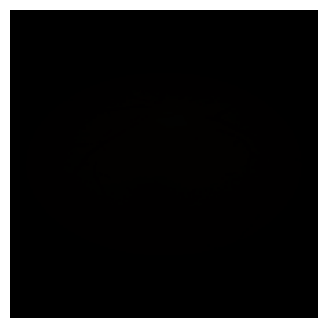

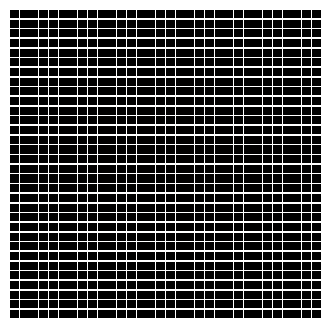

In [8]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [127]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)         

In [ ]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
 12/169 [=>............................] - ETA: 20:24 - loss: 1.2510 - accuracy: 0.2552